In [1]:
from Simulation.mpc import *
from Simulation.system_functions import PolymerCSTR
from utils.helpers import *

# Initializing The system

In [2]:
# First initiate the system
# Parameters
Ad = 2.142e17           # h^-1
Ed = 14897              # K
Ap = 3.816e10           # L/(molh)`
Ep = 3557               # K
At = 4.50e12            # L/(molh)
Et = 843                # K
fi = 0.6                # Coefficient
m_delta_H_r = -6.99e4   # j/mol
hA = 1.05e6             # j/(Kh)
rhocp = 1506            # j/(Kh)
rhoccpc = 4043          # j/(Kh)
Mm = 104.14             # g/mol
system_params = np.array([Ad, Ed, Ap, Ep, At, Et, fi, m_delta_H_r, hA, rhocp, rhoccpc, Mm])

In [3]:
# Design Parameters
CIf = 0.5888    # mol/L
CMf = 8.6981    # mol/L
Qi = 108.       # L/h
Qs = 459.       # L/h
Tf = 330.       # K
Tcf = 295.      # K
V = 3000.       # L
Vc = 3312.4     # L

system_design_params = np.array([CIf, CMf, Qi, Qs, Tf, Tcf, V, Vc])

In [4]:
# Steady State Inputs
Qm_ss = 378.    # L/h
Qc_ss = 471.6   # L/h

system_steady_state_inputs = np.array([Qc_ss, Qm_ss])

In [5]:
# Sampling time of the system
delta_t = 0.5 # 30 mins

In [6]:
# Initiate the CSTR for steady state values
cstr = PolymerCSTR(system_params, system_design_params, system_steady_state_inputs, delta_t)
steady_states={"ss_inputs":cstr.ss_inputs,
               "y_ss":cstr.y_ss}

## Loading the system matrices, min max scaling, and min max of the states

In [7]:
dir_path = os.path.join(os.getcwd(), "Data")

In [8]:
# Defining the range of setpoints for data generation
setpoint_y = np.array([[2.8, 320.],
                       [5., 326.]])
u_min = np.array([71.6, 78])
u_max = np.array([870, 670])

system_data = load_and_prepare_system_data(steady_states=steady_states, setpoint_y=setpoint_y, u_min=u_min, u_max=u_max)

In [9]:
A_aug = system_data["A_aug"]
B_aug = system_data["B_aug"]
C_aug = system_data["C_aug"]

In [10]:
data_min = system_data["data_min"]
data_max = system_data["data_max"]

In [11]:
# min_max_states = system_data["min_max_states"]
# min_max_states = system_data["min_max_states"]
min_max_states = {'max_s': np.array([256.79686253, 256.01560603,  48.99447186, 144.79949103,
          2.82199733,   3.14014989,   2.78866348,   3.71691422,
          6.2029936 ]),
                  'min_s': np.array([ -272.28060121, -1112.33972595,   -76.63993491,  -608.60327886,
           -3.94399122,    -3.93115257,    -2.9532091 ,    -4.06547624,
          -28.25906582])}

In [12]:
y_sp_scaled_deviation = system_data["y_sp_scaled_deviation"]

In [13]:
b_min = system_data["b_min"]
b_max = system_data["b_max"]

In [14]:
min_max_dict = system_data["min_max_dict"]
min_max_dict["x_max"] = np.array([256.79686253, 256.01560603,  48.99447186, 144.79949103,
          2.82199733,   3.14014989,   2.78866348,   3.71691422,
          6.2029936 ])
min_max_dict["x_min"] = np.array([ -272.28060121, -1112.33972595,   -76.63993491,  -608.60327886,
           -3.94399122,    -3.93115257,    -2.9532091 ,    -4.06547624,
          -28.25906582])

In [15]:
min_max_dict

{'x_max': array([256.79686253, 256.01560603,  48.99447186, 144.79949103,
          2.82199733,   3.14014989,   2.78866348,   3.71691422,
          6.2029936 ]),
 'x_min': array([ -272.28060121, -1112.33972595,   -76.63993491,  -608.60327886,
           -3.94399122,    -3.93115257,    -2.9532091 ,    -4.06547624,
          -28.25906582]),
 'y_sp_min': array([-4.91766443, -4.61204935]),
 'y_sp_max': array([5.00776949, 3.06512771]),
 'u_max': array([9.96, 7.3 ]),
 'u_min': array([-10. ,  -7.5])}

In [16]:
# Setpoints in deviation form
inputs_number = int(B_aug.shape[1])
y_sp_scenario = np.array([[4.5, 324],
                          [3.4, 321]])

y_sp_scenario = (apply_min_max(y_sp_scenario, data_min[inputs_number:], data_max[inputs_number:])
                 - apply_min_max(steady_states["y_ss"], data_min[inputs_number:], data_max[inputs_number:]))
n_tests = 2
set_points_len = 400
TEST_CYCLE = [False, False, False, False, False]
warm_start = 10
ACTOR_FREEZE = 10 * set_points_len
warm_start_plot = warm_start * 2 * set_points_len + ACTOR_FREEZE

In [17]:
# Observer Gain
poles = np.array(np.array([0.44619852, 0.33547649, 0.36380595, 0.70467118, 0.3562966,
                           0.42900673, 0.4228262 , 0.96916776, 0.91230187]))
L = compute_observer_gain(A_aug, C_aug, poles)

The system is observable.


C:\Users\HAMEDI\OneDrive - McMaster University\PythonProjects\Polymer_example\Simulation\mpc.py:124: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a tolerance of 0.001, we got 0.9999999422182039.
  obs_gain_calc = signal.place_poles(A.T, C.T, desired_poles, method='KNV0')


## Setting The hyperparameters for the TD3 Agent


In [18]:
from TD3Agent.agent import TD3Agent
import torch

In [19]:
set_points_number = int(C_aug.shape[0])
STATE_DIM = int(A_aug.shape[0]) + set_points_number + inputs_number
ACTION_DIM = int(B_aug.shape[1])
n_outputs = C_aug.shape[0]
ACTOR_LAYER_SIZES = [512, 512, 512, 512, 512]
CRITIC_LAYER_SIZES = [512, 512, 512, 512, 512]
BUFFER_CAPACITY = 300000
ACTOR_LR = 1e-4
CRITIC_LR = 1e-4
SMOOTHING_STD = 0.01
NOISE_CLIP = 0.1
EXPLORATION_NOISE_STD = 0.01
GAMMA = 0.9999
TAU = 0.005
MAX_ACTION = 1
POLICY_DELAY = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
STD_START = 0.02
STD_END = 0.0
STD_DECAY_RATE = 0.99995
STD_DECAY_MODE = "exp"

In [20]:
td3_agent = TD3Agent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    actor_hidden=ACTOR_LAYER_SIZES,
    critic_hidden=CRITIC_LAYER_SIZES,
    gamma=GAMMA,
    actor_lr=ACTOR_LR,
    critic_lr=CRITIC_LR,
    batch_size=BATCH_SIZE,
    policy_delay=POLICY_DELAY,
    target_policy_smoothing_noise_std=SMOOTHING_STD,
    noise_clip=NOISE_CLIP,
    max_action=MAX_ACTION,
    tau=TAU,
    std_start=STD_START,
    std_end=STD_END,
    std_decay_rate=STD_DECAY_RATE,
    std_decay_mode=STD_DECAY_MODE,
    buffer_size=BUFFER_CAPACITY,
    device=DEVICE,
    actor_freeze=ACTOR_FREEZE,
    )

In [21]:
agent_path = r"C:\Users\HAMEDI\OneDrive - McMaster University\PythonProjects\Polymer_example\Data\models\agent_2507171027.pkl"
td3_agent.load(agent_path)

Agent loaded successfully from: C:\Users\HAMEDI\OneDrive - McMaster University\PythonProjects\Polymer_example\Data\models\agent_2507171027.pkl


In [22]:
# MPC parameters
predict_h = 9
cont_h = 3
b1 = (b_min[0], b_max[0])
b2 = (b_min[1], b_max[1])
bnds = (b1, b2)*cont_h
cons = []
IC_opt = np.zeros(inputs_number*cont_h)
Q1_penalty = 12
Q2_penalty = 8
R1_penalty = 1
R2_penalty = 1
Q1_penalty_mpc = 5
Q2_penalty_mpc = 1
Q_penalty = np.array([[Q1_penalty, 0], [0, Q2_penalty]])
R_penalty = np.array([[R1_penalty, 0], [0, R2_penalty]])

In [23]:
MPC_obj = MpcSolver(A_aug, B_aug, C_aug,
                    Q1_penalty_mpc, Q2_penalty_mpc, R1_penalty, R2_penalty,
                    predict_h, cont_h)

## Applying RL Agent on the Distillation column

In [24]:
def run_rl(system, y_sp_scenario, n_tests, set_points_len,
            steady_states, min_max_dict, agent, MPC_obj,
            Q1_penalty, Q2_penalty, R1_penalty, R2_penalty, L, data_min, data_max, n_inputs):
    # defining setpoints
    y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes = generate_setpoints(y_sp_scenario, n_tests,
                                                                                    set_points_len)
    
    # Set Agent Exploration to zero
    agent.warm_start = False

    # Output of the system
    y_system = np.zeros((nFE + 1, MPC_obj.C.shape[0]))
    y_system[0, :] = system.current_output
    
    # RL inputs
    u_rl = np.zeros((nFE, MPC_obj.B.shape[1]))

    # Record states of the state space model
    xhatdhat = np.zeros((MPC_obj.A.shape[0], nFE + 1))
    yhat = np.zeros((MPC_obj.C.shape[0], nFE))

    # Reward recording
    rewards = np.zeros(nFE)
    avg_rewards = []
    
    # Scaled steady states inputs and outputs
    ss_scaled_inputs = apply_min_max(steady_states["ss_inputs"], data_min[:n_inputs], data_max[:n_inputs])
    y_ss_scaled = apply_min_max(steady_states["y_ss"], data_min[n_inputs:], data_max[n_inputs:])

    # MPC inputs
    u_mpc = np.zeros((nFE, MPC_obj.B.shape[1]))
    
    # Minimum and Maximum of the rl action
    u_min, u_max = min_max_dict["u_min"], min_max_dict["u_max"]

    for i in range(nFE):
        # So we need to apply scaling for rl because the formulation of the MPC was in scaled deviation
        # current input needs to be scaled and then deviation form
        # y_sp is already in scaled and deviation form
        # States from state space model is scaled deviation from as well
        scaled_current_input = apply_min_max(system.current_input, data_min[:n_inputs], data_max[:n_inputs])
        scaled_current_input_dev = scaled_current_input - ss_scaled_inputs

        # Set the current state
        current_rl_state = apply_rl_scaled(min_max_dict, xhatdhat[:, i], y_sp[i, :], scaled_current_input_dev)

        # Let's take u_mpc to check as well
        # Solving MPC optimization problem
        sol = spo.minimize(
            lambda x: MPC_obj.mpc_opt_fun(x, y_sp[i, :], (scaled_current_input - ss_scaled_inputs),
                                          xhatdhat[:, i]), IC_opt, bounds=bnds, constraints=cons)
        # take the first control action (this is in scaled deviation form)
        u_mpc[i, :] = sol.x[:MPC_obj.B.shape[1]] + ss_scaled_inputs

        # Taking the action of the TD3 Agent
        action = agent.take_action(current_rl_state)

        # First converting the action into the scaled mpc from rl scaled
        u = ((action + 1.0) / 2.0) * (u_max - u_min) + u_min

        # take the control action (this is in scaled deviation form)
        u_rl[i, :] = u + ss_scaled_inputs

        # u (reverse scaling of the mpc)
        u_plant = reverse_min_max(u_rl[i, :], data_min[:n_inputs], data_max[:n_inputs])

        # Calculate Delta U in scaled deviation form
        delta_u = (u_rl[i, :] - ss_scaled_inputs) - (scaled_current_input - ss_scaled_inputs)

        # Change the current input
        system.current_input = u_plant

        # Apply the action on the system
        system.step()

        # Record the system output
        y_system[i + 1, :] = system.current_output

        # # Since the state space calculation is in scaled will transform it
        # y_current_scaled = apply_min_max(y_system[i, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled

        # Transform the system output into scaled deviation form
        y_current_scaled = apply_min_max(y_system[i+1, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled
        y_current_scaled_model = apply_min_max(y_system[i, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled

        # Calculate Delta y in deviation form
        delta_y = y_current_scaled - y_sp[i, :]

        # Calculate the next state in deviation form
        yhat[:, i] = np.dot(MPC_obj.C, xhatdhat[:, i])
        xhatdhat[:, i + 1] = np.dot(MPC_obj.A, xhatdhat[:, i]) + np.dot(MPC_obj.B,
                                                                        (u_rl[i, :] - ss_scaled_inputs)) + \
                             np.dot(L, (y_current_scaled_model - yhat[:, i])).T

        # Reward Calculation
        reward = - (Q1_penalty * delta_y[0] ** 2 + Q2_penalty * delta_y[1] ** 2 +
                    R1_penalty * delta_u[0] ** 2 + R2_penalty * delta_u[1] ** 2)

        # # Overall error: norm difference between current scaled output and setpoint
        # error_norm = np.linalg.norm((y_current_scaled - y_sp[i, :]).reshape(1, -1), axis=0)
        # error_norm = np.abs(error_norm / (y_sp[i, :] + 1e-15)) * 100.0
        #
        # if np.all(error_norm <= 5):
        #     mean_error = np.mean(error_norm)
        #     # reward_bonus = logistic_bonus(mean_error)
        #     reward_bonus = exponential_decay_bonus(mean_error, A=1000)
        #     # reward_bonus = logarithmic_bonus(mean_error, max_percentage_error=5, A=5)
        #     # reward_bonus = polynomial_bonus(mean_error)
        #     reward += reward_bonus

        # Record rewards
        rewards[i] = reward
        
        

        # Calculate average reward and printing
        if i in sub_episodes_changes_dict.keys():
            # Averaging the rewards from the last setpoint change till current
            avg_rewards.append(np.mean(rewards[i - time_in_sub_episodes + 1: i]))

            # printing
            print('Sub_Episode : ', sub_episodes_changes_dict[i], ' | avg. reward :', avg_rewards[-1])

    u_rl = reverse_min_max(u_rl, data_min[:n_inputs], data_max[:n_inputs])
    u_mpc = reverse_min_max(u_mpc, data_min[:n_inputs], data_max[:n_inputs])

    return y_system, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, u_mpc

In [25]:
cstr = PolymerCSTR(system_params, system_design_params, system_steady_state_inputs, delta_t)
y_rl, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat, u_mpc = run_rl(cstr, y_sp_scenario, n_tests, set_points_len,
            steady_states, min_max_dict, td3_agent, MPC_obj,
            Q1_penalty, Q2_penalty, R1_penalty, R2_penalty, L, data_min, data_max, inputs_number)

Sub_Episode :  1  | avg. reward : -10.057174347410896
Sub_Episode :  2  | avg. reward : -13.29051127140705


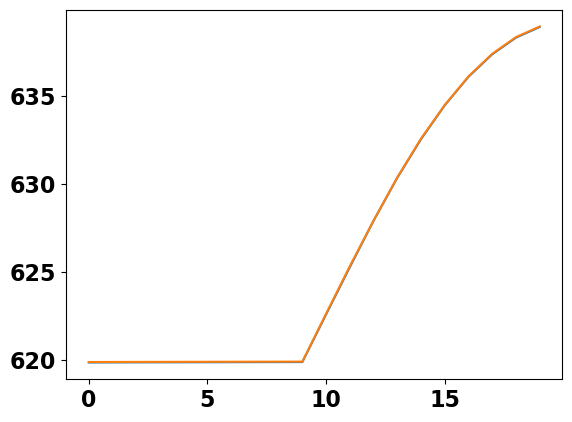

In [32]:
plt.plot(u_rl[390:410, 0])
plt.plot(u_mpc[390:410, 0])

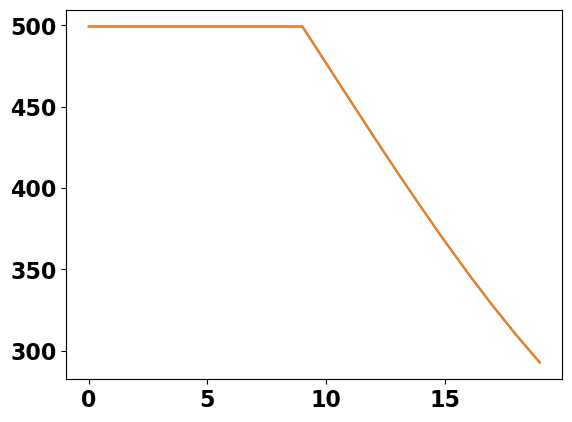

In [35]:
plt.plot(u_rl[390:410, 1])
plt.plot(u_mpc[390:410, 1])

In [36]:
save_path = os.path.join(dir_path, "mpc_results.pickle")
with open(save_path, 'rb') as file:
    mpc_results = pickle.load(file)

In [37]:
def plot_rl_mpc(y_sp, steady_states, nFE, delta_t, y_rl, u_rl, mpc_results, data_min,
                data_max, xhatdhat):
    
    # Canceling the deviation form
    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T
    
    time_plot = np.linspace(0, nFE * delta_t, nFE + 1)

    y_mpc = mpc_results["y_mpc"]
    u_mpc = mpc_results["u_mpc"]
    xhatdhat_mpc = mpc_results["xhatdhat"]
    
    ####### Plot 1  ###############
    
    plt.figure(figsize=(10, 8))

    # First subplot
    plt.subplot(2, 1, 1)
    plt.plot(time_plot, y_rl[:, 0], 'b-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot, y_mpc[:, 0], 'y--', lw=2, label=r'$\mathbf{MPC}$')
    plt.step(time_plot[:-1], y_sp[0, :], 'r--', lw=2, label=r'$\mathbf{Setpoint}$')
    plt.ylabel(r'$\mathbf{\eta}$ (L/g)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    # Second subplot
    plt.subplot(2, 1, 2)
    plt.plot(time_plot, y_rl[:, 1], 'b-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot, y_mpc[:, 1], 'y--', lw=2, label=r'$\mathbf{MPC}$')
    plt.step(time_plot[:-1], y_sp[1, :], 'r--', lw=2, label=r'$\mathbf{Setpoint}$')
    plt.ylabel(r'$\mathbf{T}$ (K)', fontsize=18)
    plt.xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)

    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()
    
    ####### Plot 2  ###############
    plt.figure(figsize=(10, 8))

    # First subplot
    plt.subplot(2, 1, 1)
    plt.plot(time_plot[:-1], u_rl[:, 0], 'r-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot[:-1], u_mpc[:, 0], 'b--', lw=2, label=r'$\mathbf{MPC}$')
    plt.ylabel(r'$\mathbf{Q}_c$ (L/h)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    # Second subplot
    plt.subplot(2, 1, 2)
    plt.plot(time_plot[:-1], u_rl[:, 1], 'r-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot[:-1], u_mpc[:, 1], 'b--', lw=2, label=r'$\mathbf{MPC}$')
    plt.ylabel(r'$\mathbf{Q}_m$ (L/h)', fontsize=18)
    plt.xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)

    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()
    
    
    ###### Plot 3 ########
    fig, axes = plt.subplots(nrows=xhatdhat.shape[0], ncols=1, 
                         figsize=(10, 3 * xhatdhat.shape[0]), 
                         sharex=True)
    
    for i in range(xhatdhat.shape[0]):
        # Plot RL (xhatdhat)
        axes[i].plot(time_plot, xhatdhat[i, :], 'r-', lw=2, label='RL')
        # Plot MPC (xhatdhat_mpc)
        axes[i].plot(time_plot, xhatdhat_mpc[i, :], 'y--', lw=2, label='MPC', alpha=0.6)
        
        # Labeling, grids, etc.
        axes[i].grid(True)
        axes[i].set_ylabel(f'State {i}', fontsize=14)
        axes[i].legend(loc='best', fontsize=12)
    
    # Label the bottom (shared) X-axis:
    axes[-1].set_xlabel('Time (h)', fontsize=14)
    
    fig.suptitle('Comparison of RL vs. MPC States', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.show()

In [38]:
plot_rl_mpc(y_sp, steady_states, nFE, delta_t, y_rl, u_rl, mpc_results, data_min,
                data_max, xhatdhat)

KeyError: 'xhatdhat'

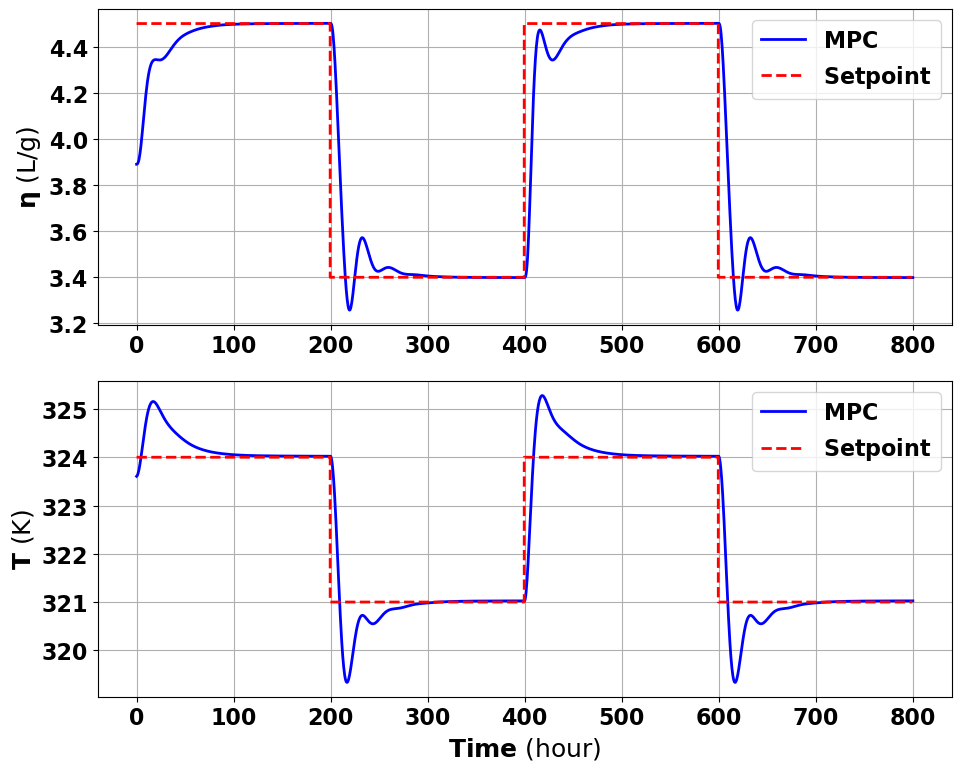

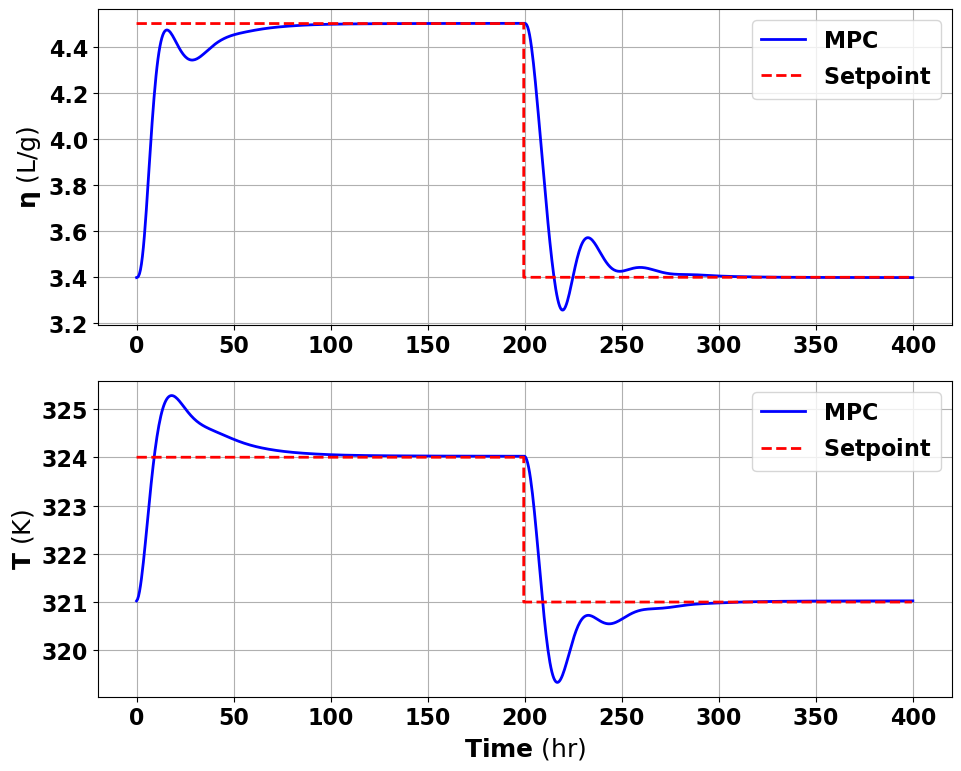

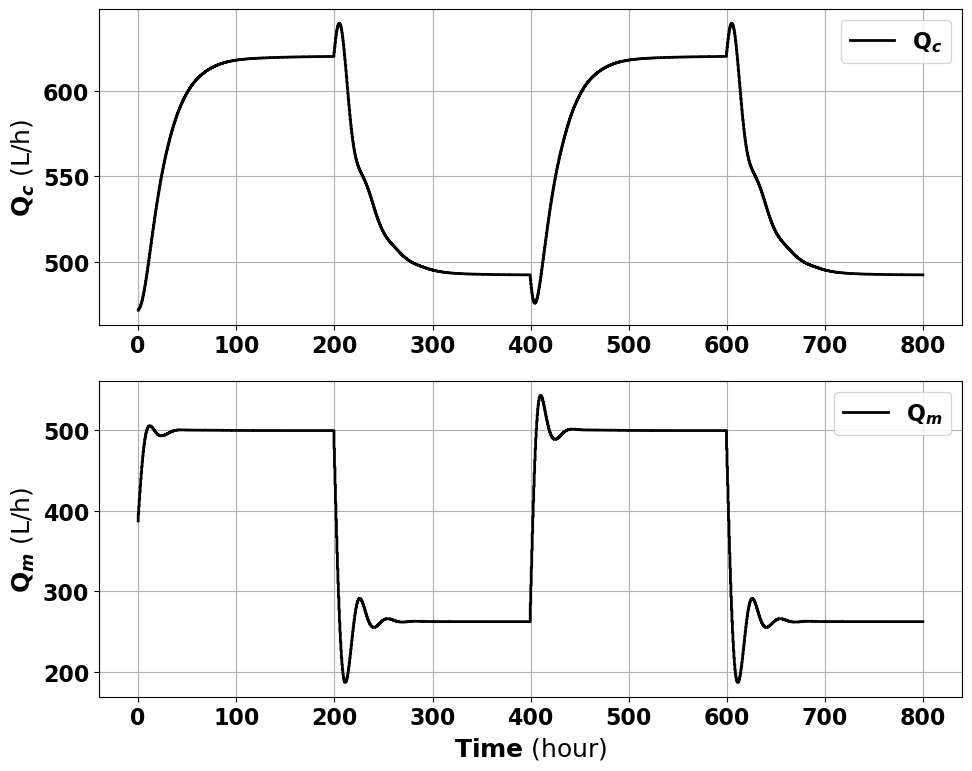

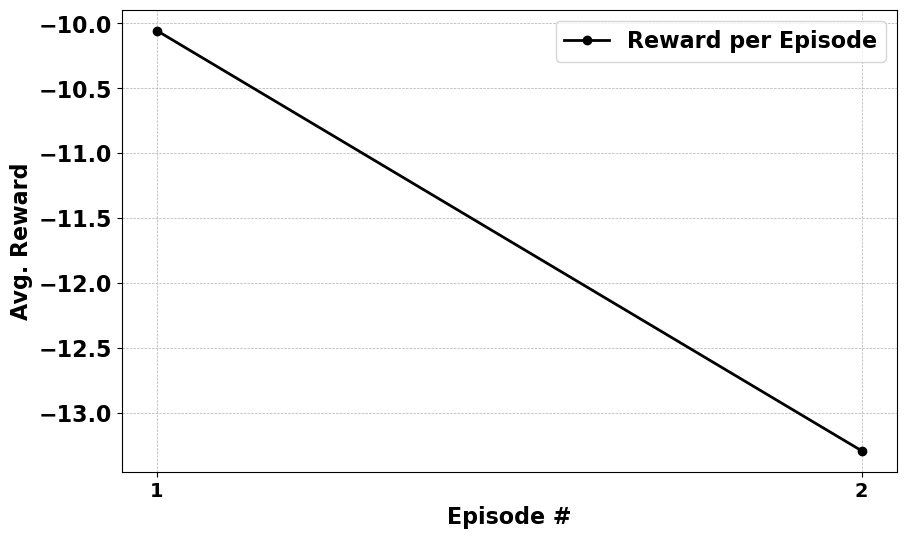

In [39]:
plot_mpc_results(y_sp, steady_states, nFE, delta_t, time_in_sub_episodes, y_rl, u_rl, avg_rewards, data_min, data_max, yhat)

In [78]:
# y_sp = y_sp[400:]
point_numbers = len(y_sp)
x_d_states = np.zeros((point_numbers+1, A.shape[0]))
next_x_d_states = np.zeros((point_numbers, A.shape[0]))
u_record = np.zeros((point_numbers, B.shape[1]))
u_record[0, :] = scaler_u.inverse_transform(u_ss.reshape(1, -1))
y_hat = np.zeros_like(y_sp)
y_process_record = np.zeros_like(y_sp)
y_process_record[0, :] = scaler_y.inverse_transform(y_ss.reshape(1, -1))
y_unscaled_record = np.zeros_like(y_sp)
y_unscaled_record[0] = y_ss
rl_rewards_record = np.zeros((point_numbers, 1))
u_record[0, :] = u_ss
x_d_states[0, :] = 0.0
u_pts = u_ss
u_mpc_rl_action =np.zeros((point_numbers, 4))

NameError: name 'A' is not defined

In [ ]:
for i in range(point_numbers - 1):
    # First with current state space states and current setpoint and current u define state of RL
    state = apply_scaling_state(x_d_states[i, :], y_sp[i, :], u_pts, DEVICE)
    
    # With this State get the RL Agent Action
    # TODO Let's see if the behavior of the mpc is exact like giving the current states is it giving the same answer?
    # TODO If this is the problem we can change the scaler of the system identification for u to -1, 1
    # TODO for steady state not only give zero but also give very small numbers as well Done
    action = agent.take_action(state)
    
    # Checking the mpc action
    sol = spo.minimize(lambda x: MPC_obj.mpc_opt_fun(x, y_sp[i, :],
                                             (u_pts - u_ss), x_d_states[i, :]),
                       IC_opt, bounds=bnds, constraints=cons)
    u_mpc = sol.x[:B.shape[1]]
    
    # Find the U process with the un-scale from RL to MPC
    u_last = u_pts
    u_pts = ((action + 1.0) / 2.0) * (min_max_dict["u_max"] - min_max_dict["u_min"]) + min_max_dict["u_min"] + u_ss
    delta_u = u_pts - u_last
    
    u_mpc_rl_action[i, :] = np.array([u_mpc[0], u_mpc[1], u_pts[0], u_pts[1]])
    
    # Un-scale from MPC to Aspen
    # TODO this was action and I changed it to u_pts
    # TODO Create a logbook for every change you are making in training
    # TODO Maybe something is wrong in the state calculation
    # TODO MPC and RL are exactly the same now
    # TODO different exploration for different actions
    ##### TODO This part is very important
    # In the next hat state calculation it is taking the previous output in the mpc but current output in the RL
    # TODO I changed it to y_mpc[i+1] but still how this be calculated is not the same in app.step check that as well ****************
    # TODO Also reward calculation check that too
    u = scaler_u.inverse_transform(u_pts.reshape(1, -1))
    
    # Apply this input to the system
    # TODO I changed this from list to flatten() y = app.step(u.tolist()[0], scaler_y)
    # TODO Why the reward which is an objective function is not the same as mpc including control and prediction horizon
    # TODO In RL assisted MPC why only adding the output, and also why not the reward calculation changes
    # TODO Try to implement weight deccay (maybeonly for critic optimizer)
    # TODO in the pictures composition is the same but temp got better figure out this
    # TODO because it's dynamic you an't get a good reward with immediate state you need almost steady state
    # for example you can specify the control horizon at 1 at prediction horizon at 4 to see how would be the system ther
    # TODO The RL agent has to be the same as mpc like if mpc is giving three control action and 6 prediction horizon and optimizing according to that the rl has to give three inputs and take the 6 prediction and optimizing over that and then take the first action
    y = app.step(u.flatten(), scaler_y)
    
    # Record the un-scaled inputs and outputs of the system and scaled outputs for comparison with observer
    y_unscaled_record[i+1, :] = y
    y_process_record[i+1, :] = scaler_y.inverse_transform(y.reshape(1, -1))
    u_record[i+1, :] = u
    
    # Calculating the next state of the state space model, and predicted output
    y_hat[i, :] = np.dot(C, x_d_states[i, :])
    next_x_d_states[i, :] = np.dot(A, x_d_states[i, :]) + np.dot(B, u_pts) + np.dot(L, ((y_unscaled_record[i, :]-y_ss) - y_hat[i, :])).T
    
    # This next state would be the current state for the next iteration so
    x_d_states[i+1, :] = next_x_d_states[i, :]
    
    # Define the next state for the RL
    next_state = apply_scaling_state(next_x_d_states[i, :], y_sp[i, :], u_pts, DEVICE)
    
    # Calculate the reward for this episode
    rl_rewards_record[i] = -1 * ((y - y_sp[i, :]).reshape(-1, 1).T@Q_penalty@(y - y_sp[i, :]).reshape(-1, 1) + delta_u.reshape(-1, 1).T@R_penalty@delta_u.reshape(-1, 1))
    
    if i % 400 == 0 and i != 0:

        # Average reward for that setpoint
        reward_average = np.mean(rl_rewards_record[i-400: i])
        print(f'Average reward : {reward_average}')